In [ ]:
#This part is for testing different hyper parameters
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
# Import necessary libraries
from google.colab import drive
drive.mount('/content/drive')

# Load data
df = pd.read_csv('/content/drive/My Drive/drugdata.csv')
df=df.iloc[:, :6]
df = df.dropna()
X = df.iloc[:, :5]
y = df.iloc[:, 5]
d = 1000000

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

# Reshape the data to fit into LSTM input format (samples, time steps, features)
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Function to calculate evaluation metrics including RAE
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    rrmse = rmse / (np.max(y_true) - np.min(y_true))
    r2 = r2_score(y_true, y_pred)
    aapre = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    # RAE calculation
    rae = np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true - np.mean(y_true)))

    return mae, mse, rmse, rrmse, r2, aapre, rae

# Define the hyperparameter search space
lstm_units = list(range(1, 1000))  # LSTM units


# Variable to track the best model
best_params = None
best_test_r2 = -np.inf
results = {}

# Exhaustive search over LSTM units
model_id = 0
for lstm_unit in lstm_units:
    model_id += 1

    # Build the LSTM model with specified LSTM units
    model = Sequential()
    model.add(LSTM(units=lstm_unit, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
    model.add(Dense(10, activation='relu'))  # Example dense layer with fixed 10 units
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    # Train the model
    model.fit(X_train_scaled, y_train_scaled, epochs=500, batch_size=32, verbose=0, validation_split=0.15)

    # Make predictions
    y_train_pred_scaled = model.predict(X_train_scaled).flatten()
    y_test_pred_scaled = model.predict(X_test_scaled).flatten()

    # Denormalize the predictions
    y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()
    y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()

    # Calculate metrics for training and testing sets
    train_mae, train_mse, train_rmse, train_rrmse, train_r2, train_aapre, train_rae = calculate_metrics(y_train/d, y_train_pred/d)
    test_mae, test_mse, test_rmse, test_rrmse, test_r2, test_aapre, test_rae = calculate_metrics(y_test/d, y_test_pred/d)

    # Save results
    results[model_id] = {
        "lstm_units": lstm_unit,
        "train_mae": train_mae, "train_mse": train_mse, "train_rmse": train_rmse, "train_rrmse": train_rrmse,
        "train_r2": train_r2, "train_aapre": train_aapre, "train_rae": train_rae,
        "test_mae": test_mae, "test_mse": test_mse, "test_rmse": test_rmse, "test_rrmse": test_rrmse,
        "test_r2": test_r2, "test_aapre": test_aapre, "test_rae": test_rae
    }

    # Update the best configuration
    if test_r2 > best_test_r2:
        best_test_r2 = test_r2
        best_params = lstm_unit

# Print the best model configuration and performance metrics
print(f"Best LSTM units: {best_params}")
print(f"Best Test R²: {best_test_r2}")

# Print results for all models
for model_id, result in results.items():
    print(f"Model {model_id}: LSTM units={result['lstm_units']}")
    print(f"Train R²: {result['train_r2']:.4f}, Test R²: {result['test_r2']:.4f}")
    print(f"Test MAE: {result['test_mae']:.4f}, Test RMSE: {result['test_rmse']:.4f}, Test R²: {result['test_r2']:.4f}\n")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


KeyboardInterrupt: 

Mounted at /content/drive
Processing Fold 1...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Processing Fold 2...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Processing Fold 3...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Processing Fold 4...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 1
Train MAE: 0.0000, Test MAE: 0.0001
Train MSE: 0.0000, Test MSE: 0.0000
Train RMSE: 0.0001, Test RMSE: 0.0001
Train RRMSE: 0.0128, Test RRMSE: 0.0283
Train R²: 0.9822, Test R²: 0.9343
Train AAPRE: 558.7943%, Test AAPRE: 529.0724%
Train RAE: 0.1738, Test RAE: 0.2978

Fold 2
Train MAE: 0.0000, Test MAE: 0.0000
Train MSE: 0.0000, Test MSE: 0.0000
Train RMSE: 0.0001, Test RMSE: 0.0001
Train RRMSE: 0.0110, Test RRMSE: 0.0163
Train R²: 0.9864, Test R²: 0.9754
Train AAPRE: 227.2582%, Test AAPRE: 308.1323%
Train RAE: 0.1353, Test RAE: 0.1838

Fold 3
Train MAE: 0.0000, Test MAE: 0.0001
Train MSE: 0.0000, Test MSE: 0.0000
Train RMSE: 0.0001, Test RMSE: 0.0001
Train RRMSE: 0.0166, Test RRMSE: 0.0224
Train R²: 0.9787, Test R²: 0.9479
Train AAPRE: 513.4844%, Test AAPRE: 458.1209%
Train RAE: 0.1846, Test RAE: 0.2230

Fold 4
Train MAE: 0.0000, Test MAE: 0.0000
Train MSE: 0.0000, Test MSE: 0.0000
Train RMSE: 0.0001, T

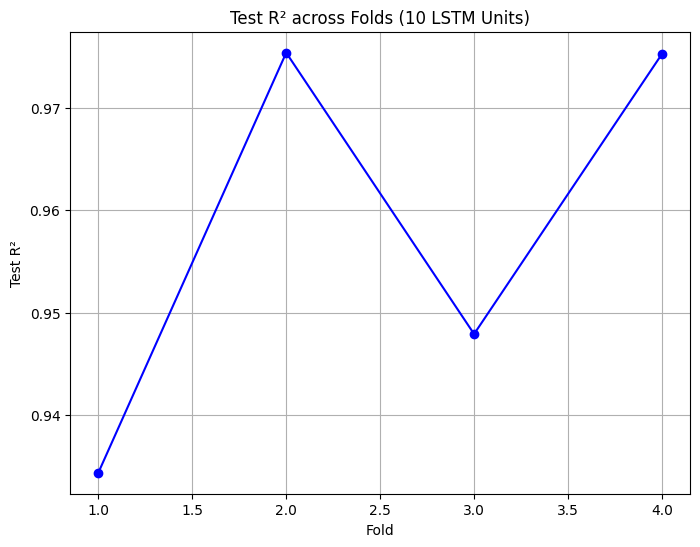

In [ ]:
#This part is for performing cross-validation on the best model
# Import necessary libraries
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam

# Load data
df = pd.read_csv('/content/drive/My Drive/drugdata.csv')
X = df.iloc[:, :5]
y = df.iloc[:, 5]
d = 1000000

# Initialize KFold with 4 splits
kf = KFold(n_splits=4, shuffle=True, random_state=42)

# Store results for each fold
fold_results = []

# Define the number of LSTM units
units = 10
# Function to calculate evaluation metrics including RAE
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    rrmse = rmse / (np.max(y_true) - np.min(y_true))
    r2 = r2_score(y_true, y_pred)
    aapre = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    # RAE calculation
    rae = np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true - np.mean(y_true)))

    return mae, mse, rmse, rrmse, r2, aapre, rae

for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    print(f"Processing Fold {fold}...")

    # Split the data for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Scale the data
    scaler_X = MinMaxScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    scaler_y = MinMaxScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
    y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

    # Reshape the data to fit into LSTM input format (samples, time steps, features)
    X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
    X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

    # Build the LSTM model with two additional Dense layers
    model = Sequential()
    model.add(LSTM(units=units, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=Adam(), loss='mse')

    # Train the model
    model.fit(X_train_scaled, y_train_scaled, epochs=1000, batch_size=32, verbose=0, validation_split=0.15)

    # Make predictions
    y_train_pred_scaled = model.predict(X_train_scaled).flatten()
    y_test_pred_scaled = model.predict(X_test_scaled).flatten()

    # Denormalize the predictions
    y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()
    y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()

    # Calculate metrics for training and testing sets
    train_mae, train_mse, train_rmse, train_rrmse, train_r2, train_aapre, train_rae = calculate_metrics(y_train/d, y_train_pred/d)
    test_mae, test_mse, test_rmse, test_rrmse, test_r2, test_aapre, test_rae = calculate_metrics(y_test/d, y_test_pred/d)

    # Save results for this fold
    fold_results.append({
        "fold": fold,
        "train_mae": train_mae, "train_mse": train_mse, "train_rmse": train_rmse, "train_rrmse": train_rrmse,
        "train_r2": train_r2, "train_aapre": train_aapre, "train_rae": train_rae,
        "test_mae": test_mae, "test_mse": test_mse, "test_rmse": test_rmse, "test_rrmse": test_rrmse,
        "test_r2": test_r2, "test_aapre": test_aapre, "test_rae": test_rae
    })

# Print results for each fold
for result in fold_results:
    print(f"Fold {result['fold']}")
    print(f"Train MAE: {result['train_mae']}, Test MAE: {result['test_mae']}")
    print(f"Train MSE: {result['train_mse']}, Test MSE: {result['test_mse']}")
    print(f"Train RMSE: {result['train_rmse']:.4f}, Test RMSE: {result['test_rmse']:.4f}")
    print(f"Train RRMSE: {result['train_rrmse']:.4f}, Test RRMSE: {result['test_rrmse']:.4f}")
    print(f"Train R²: {result['train_r2']:.4f}, Test R²: {result['test_r2']:.4f}")
    print(f"Train RAE: {result['train_rae']:.4f}, Test RAE: {result['test_rae']:.4f}\n")

# Plot the test R² for each fold
test_r2_values = [result["test_r2"] for result in fold_results]

plt.figure(figsize=(8, 6))
plt.plot(range(1, 5), test_r2_values, marker='o', linestyle='-', color='b')
plt.xlabel('Fold')
plt.ylabel('Test R²')
plt.title('Test R² across Folds (10 LSTM Units)')
plt.grid(True)
plt.show()


In [ ]:
for result in fold_results:
    print(f"Fold {result['fold']}")
    print(f"Train MAE: {result['train_mae']}, Test MAE: {result['test_mae']}")
    print(f"Train MSE: {result['train_mse']}, Test MSE: {result['test_mse']}")
    print(f"Train RMSE: {result['train_rmse']:.4f}, Test RMSE: {result['test_rmse']:.4f}")
    print(f"Train RRMSE: {result['train_rrmse']:.4f}, Test RRMSE: {result['test_rrmse']:.4f}")
    print(f"Train R²: {result['train_r2']:.4f}, Test R²: {result['test_r2']:.4f}")
    print(f"Train AAPRE: {result['train_aapre']:.4f}%, Test AAPRE: {result['test_aapre']:.4f}%")
    print(f"Train RAE: {result['train_rae']:.4f}, Test RAE: {result['test_rae']:.4f}\n")

Fold 1
Train MAE: 4.3229534488713396e-05, Test MAE: 5.280225205568808e-05
Train MSE: 4.597580595580607e-09, Test MSE: 7.427963565801898e-09
Train RMSE: 0.0001, Test RMSE: 0.0001
Train RRMSE: 0.0128, Test RRMSE: 0.0283
Train R²: 0.9822, Test R²: 0.9343
Train AAPRE: 558.7943%, Test AAPRE: 529.0724%
Train RAE: 0.1738, Test RAE: 0.2978

Fold 2
Train MAE: 3.349624236908531e-05, Test MAE: 3.3328620114705655e-05
Train MSE: 3.401775220824377e-09, Test MSE: 3.4128744113318208e-09
Train RMSE: 0.0001, Test RMSE: 0.0001
Train RRMSE: 0.0110, Test RRMSE: 0.0163
Train R²: 0.9864, Test R²: 0.9754
Train AAPRE: 227.2582%, Test AAPRE: 308.1323%
Train RAE: 0.1353, Test RAE: 0.1838

Fold 3
Train MAE: 4.13936594904618e-05, Test MAE: 5.5995175309799665e-05
Train MSE: 4.398706458078879e-09, Test MSE: 1.4018089818677008e-08
Train RMSE: 0.0001, Test RMSE: 0.0001
Train RRMSE: 0.0166, Test RRMSE: 0.0224
Train R²: 0.9787, Test R²: 0.9479
Train AAPRE: 513.4844%, Test AAPRE: 458.1209%
Train RAE: 0.1846, Test RAE: 0.